In [1]:
# Cell 1: Import Libraries and Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
import joblib
from datetime import datetime, timedelta

# Machine Learning Libraries
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import (LSTM, Dense, Dropout, BatchNormalization,
                                     Bidirectional, Input)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)
tf.random.set_seed(42)

# Print versions for reproducibility
print("📦 Library Versions:")
print(f"   TensorFlow: {tf.__version__}")
print(f"   Pandas: {pd.__version__}")
print(f"   NumPy: {np.__version__}")
print(f"   Scikit-learn: {sklearn.__version__}")
print("✅ All libraries imported successfully!")

📦 Library Versions:
   TensorFlow: 2.18.0
   Pandas: 2.2.2
   NumPy: 2.0.2
   Scikit-learn: 1.6.1
✅ All libraries imported successfully!


In [2]:
# Cell 2: Configuration and Global Parameters
class Config:
    """Global configuration for the irrigation prediction system"""

    # Model Parameters
    SEQUENCE_LENGTH = 48  # 2 days of hourly data
    MODEL_TYPE = 'bidirectional_lstm'  # Options: 'bidirectional_lstm', 'attention_lstm'

    # Training Parameters
    BATCH_SIZE = 64
    EPOCHS = 150
    LEARNING_RATE = 0.001
    VALIDATION_SPLIT = 0.2
    TEST_SPLIT = 0.2

    # Data Parameters
    RANDOM_STATE = 42
    STRIDE = 12  # Overlap for sequence creation

    # Feature Engineering Parameters
    ROLLING_WINDOWS = [3, 7, 24]
    LAG_FEATURES = [1, 3, 6, 12, 24]

    # File Paths
    DATASET_FILES = [
        {
            'filename': "intelligent_irrigation.csv",
            'source_name': 'kaggle_intelligent',
            'time_col': 'timestamp',
            'soil_col': 'soil_moisture',
            'temp_col': 'air_temperature',
            'hum_col': 'air_humidity',
            'irrig_col': 'irrigation_on'
        },
        {
            'filename': "tomato_irrigation.csv",
            'source_name': 'mendeley_tomato',
            'time_col': 'datetime',
            'soil_col': 'soil_moisture',
            'temp_col': 'BME280_temp',
            'hum_col': 'BME280_humidity',
            'irrig_col': 'irrigation_flag'
        },
        {
            'filename': "irrigation_machine.csv",
            'source_name': 'kaggle_machine',
            'time_col': 'datetime',
            'soil_col': 'soil_moisture_raw',
            'temp_col': 'temperature',
            'hum_col': 'humidity',
            'irrig_col': 'pump_state'
        }
    ]

# Initialize global variables
config = Config()
print("⚙️ Configuration loaded successfully!")
print(f"   Sequence Length: {config.SEQUENCE_LENGTH}")
print(f"   Model Type: {config.MODEL_TYPE}")
print(f"   Batch Size: {config.BATCH_SIZE}")


⚙️ Configuration loaded successfully!
   Sequence Length: 48
   Model Type: bidirectional_lstm
   Batch Size: 64


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harshilpatel355/autoirrigationdata")

print("Path to dataset files:", path)

100%|██████████| 2.75k/2.75k [00:00<00:00, 4.59MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/harshilpatel355/autoirrigationdata/versions/2


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahmoudshaheen1134/irrigation-machine-dataset")

print("Path to dataset files:", path)

100%|██████████| 33.1k/33.1k [00:00<00:00, 24.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mahmoudshaheen1134/irrigation-machine-dataset/versions/1


In [5]:
# Cell 3: Datase(t Loading and Standardization Functions
def create_synthetic_dataset(n_samples=10000):
    """Create realistic synthetic irrigation dataset for demonstration"""
    print("🔧 Creating synthetic dataset...")
    np.random.seed(config.RANDOM_STATE)

    # Generate timestamps (1 year of hourly data)
    start_date = datetime(2023, 1, 1)
    timestamps = [start_date + timedelta(hours=i) for i in range(n_samples)]

    data = []
    irrigation_state = 0
    soil_moisture = 50.0 # Starting soil moisture

    for i, timestamp in enumerate(timestamps):
        # Seasonal temperature patterns
        day_of_year = timestamp.timetuple().tm_yday
        seasonal_temp = 20 + 15 * np.sin(2 * np.pi * day_of_year / 365.25)
        daily_temp_variation = 8 * np.sin(2 * np.pi * timestamp.hour / 24)
        temperature = seasonal_temp + daily_temp_variation + np.random.normal(0, 2)

        # Humidity inversely related to temperature with noise
        humidity = max(20, min(95, 80 - 0.5 * (temperature - 20) + np.random.normal(0, 5)))

        # Soil moisture dynamics
        evaporation_rate = max(0, (temperature - 10) * (100 - humidity) / 1000)
        soil_moisture -= evaporation_rate + np.random.normal(0, 0.5)

        # Irrigation logic (realistic thresholds)
        if soil_moisture < 25 or (soil_moisture < 35 and temperature > 30):
            irrigation_state = 1
            soil_moisture += np.random.uniform(15, 25)
        else:
            irrigation_state = 0

        # Ensure realistic bounds
        soil_moisture = max(10, min(90, soil_moisture))

        data.append({
            'timestamp': timestamp,
            'soil_moisture': soil_moisture,
            'temperature': temperature,
            'humidity': humidity,
            'irrigation': irrigation_state,
            'dataset_source': 'synthetic_demo'
        })

    df = pd.DataFrame(data)
    print(f"✅ Synthetic dataset created: {len(df)} records")
    print(f"   Irrigation rate: {df['irrigation'].mean():.2%}")
    return df

def standardize_dataset(df, config_dict):
    """Standardize individual dataset to common format"""
    try:
        # Rename columns to common format
        df_clean = df.rename(columns={
            config_dict['soil_col']: 'soil_moisture',
            config_dict['temp_col']: 'temperature',
            config_dict['hum_col']: 'humidity',
            config_dict['irrig_col']: 'irrigation'
        }).copy()

        # Convert timestamp
        df_clean['timestamp'] = pd.to_datetime(df_clean[config_dict['time_col']],
                                             errors='coerce', infer_datetime_format=True)
        df_clean['dataset_source'] = config_dict['source_name']

        # Select required columns
        required_cols = ['timestamp', 'soil_moisture', 'temperature', 'humidity',
                        'irrigation', 'dataset_source']
        available_cols = [col for col in required_cols if col in df_clean.columns]
        df_clean = df_clean[available_cols]

        # Data cleaning and validation
        initial_count = len(df_clean)

        # Remove rows with invalid timestamps
        df_clean = df_clean.dropna(subset=['timestamp'])

        # Convert numerical columns
        numerical_cols = ['soil_moisture', 'temperature', 'humidity']
        for col in numerical_cols:
            if col in df_clean.columns:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

        # Remove rows with missing data
        df_clean = df_clean.dropna(subset=numerical_cols)

        # Outlier removal (using IQR method)
        for col in numerical_cols:
            if col in df_clean.columns:
                Q1 = df_clean[col].quantile(0.01)
                Q3 = df_clean[col].quantile(0.99)
                df_clean = df_clean[(df_clean[col] >= Q1) & (df_clean[col] <= Q3)]

        # Ensure irrigation is binary
        if 'irrigation' in df_clean.columns:
            df_clean['irrigation'] = df_clean['irrigation'].fillna(0).astype(int)
            df_clean['irrigation'] = (df_clean['irrigation'] > 0).astype(int)

        # Sort by timestamp
        df_clean = df_clean.sort_values('timestamp').reset_index(drop=True)

        print(f"    📊 {config_dict['source_name']}: {initial_count} → {len(df_clean)} records")
        return df_clean

    except Exception as e:
        print(f"    ❌ Error standardizing {config_dict['source_name']}: {e}")
        return pd.DataFrame()

def load_and_combine_datasets():
    """Load and combine all available datasets"""
    print("📚 Loading datasets...")
    datasets = []

    for dataset_config in config.DATASET_FILES:
        try:
            if os.path.exists(dataset_config['filename']):
                df = pd.read_csv(dataset_config['filename'])
                standardized_df = standardize_dataset(df, dataset_config)
                if len(standardized_df) > 0:
                    datasets.append(standardized_df)
                    print(f"✅ Loaded {dataset_config['source_name']}")
                else:
                    print(f"⚠️ Warning: {dataset_config['source_name']} empty after cleaning")
            else:
                print(f"⚠️ Warning: {dataset_config['filename']} not found")
        except Exception as e:
            print(f"❌ Error loading {dataset_config['filename']}: {e}")

    if not datasets:
        print("📊 No external datasets found. Creating synthetic data...")
        synthetic_df = create_synthetic_dataset()
        datasets.append(synthetic_df)

    # Combine all datasets
    combined_df = pd.concat(datasets, ignore_index=True)
    print(f"📈 Total combined records: {len(combined_df)}")

    return combined_df

# Execute dataset loading
raw_data = load_and_combine_datasets()
print(f"\n📋 Dataset Info:")
print(f"   Shape: {raw_data.shape}")
print(f"   Date range: {raw_data['timestamp'].min()} to {raw_data['timestamp'].max()}")
print(f"   Irrigation rate: {raw_data['irrigation'].mean():.2%}")

📚 Loading datasets...
⚠️ Warning: intelligent_irrigation.csv not found
⚠️ Warning: tomato_irrigation.csv not found
⚠️ Warning: irrigation_machine.csv not found
📊 No external datasets found. Creating synthetic data...
🔧 Creating synthetic dataset...
✅ Synthetic dataset created: 10000 records
   Irrigation rate: 1.48%
📈 Total combined records: 10000

📋 Dataset Info:
   Shape: (10000, 6)
   Date range: 2023-01-01 00:00:00 to 2024-02-21 15:00:00
   Irrigation rate: 1.48%


🔍 Data Quality Assessment
📊 Dataset Overview:
   Shape: (10000, 6)
   Memory usage: 1.06 MB
   Date range: 2023-01-01 00:00:00 to 2024-02-21 15:00:00
   Duration: 416 days

⚖️ Class Distribution:
   No Irrigation (0): 9852 (98.5%)
   Irrigation (1): 148 (1.5%)

✅ No missing values found

📊 Feature Statistics:
       soil_moisture  temperature  humidity
count       10000.00     10000.00  10000.00
mean           41.74        20.80     79.59
std             7.18        11.85      7.68
min            25.01        -8.74     54.93
25%            36.49        11.86     74.16
50%            41.81        21.28     79.60
75%            47.39        29.94     85.01
max            59.55        48.26     95.00

📁 Dataset Sources:
   synthetic_demo: 10000 records (100.0%) - Irrigation: 1.5%

✅ No duplicate records found


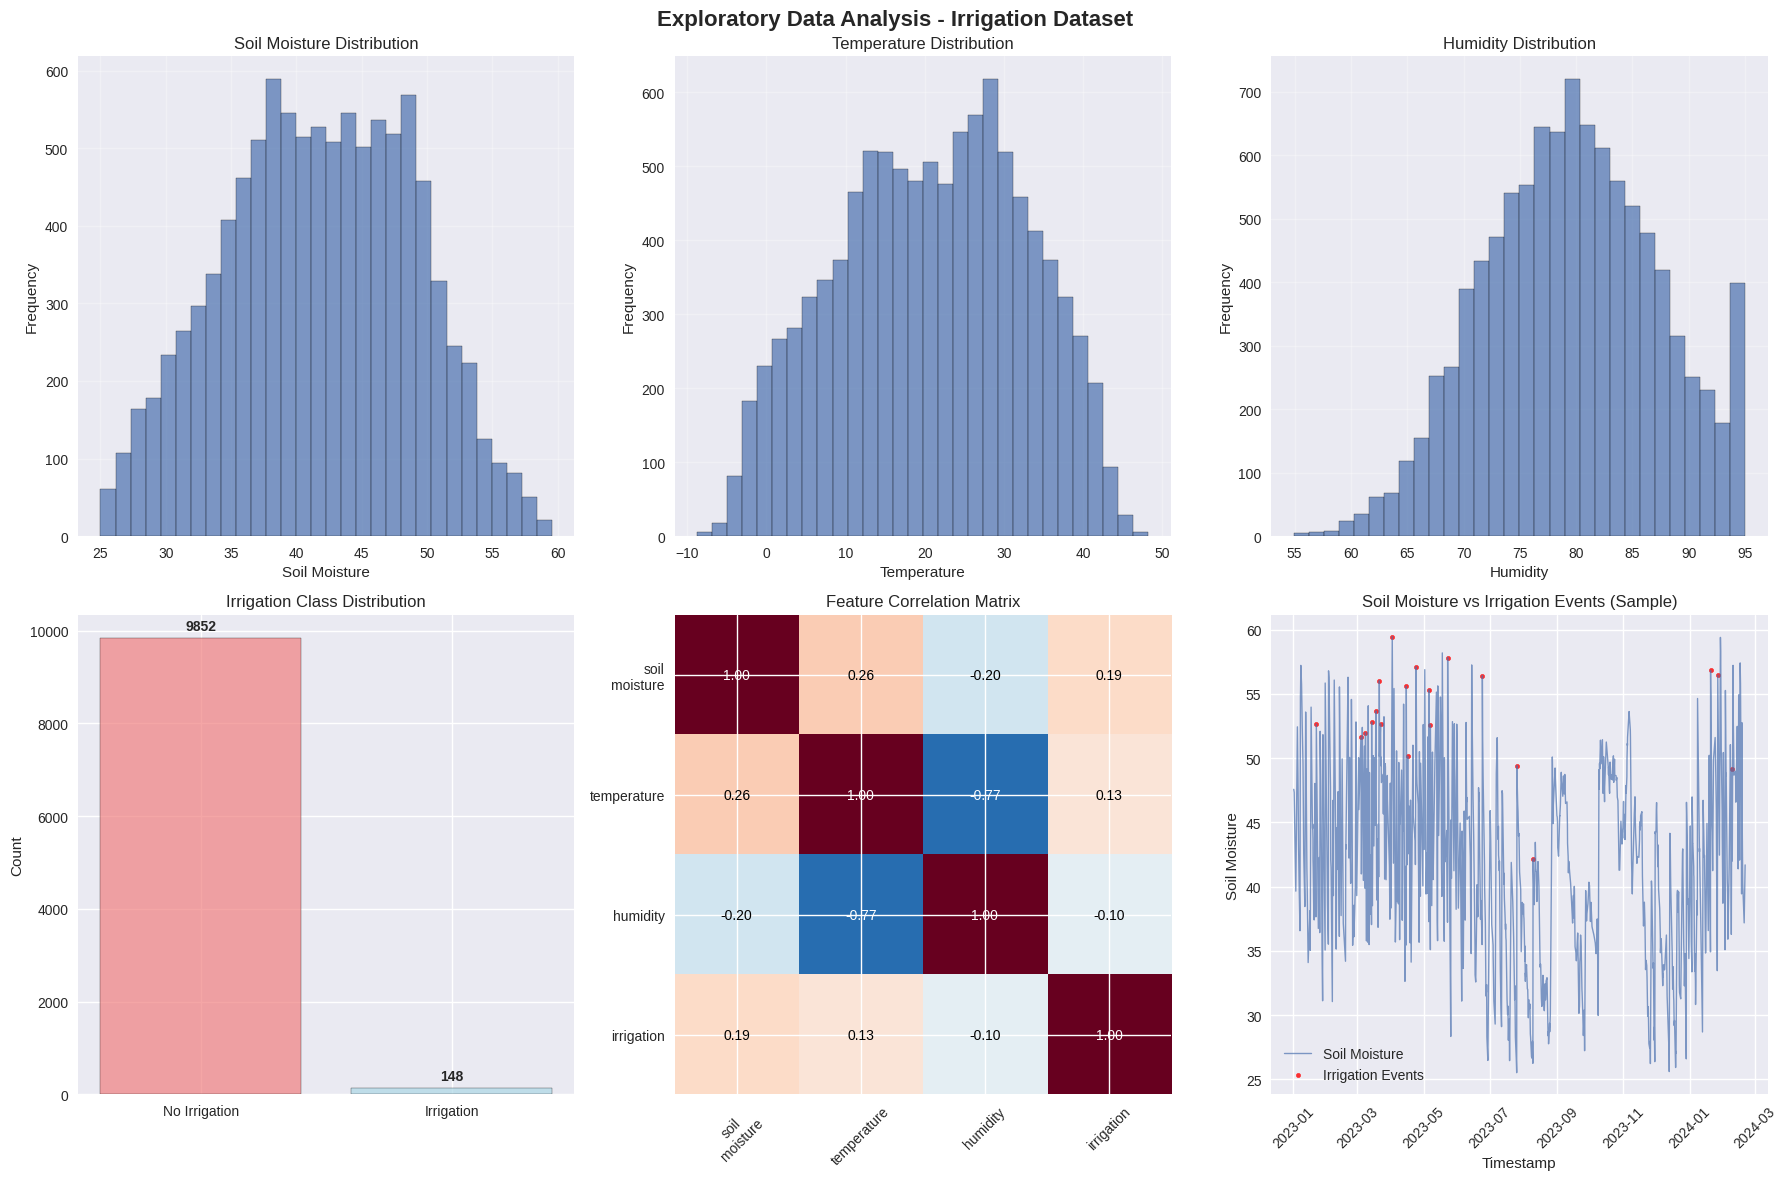

In [6]:
# Cell 4: Data Quality Assessment and Exploratory Data Analysis

def perform_data_quality_assessment(df):
    """Comprehensive data quality assessment"""
    print("🔍 Data Quality Assessment")
    print("=" * 50)

    # Basic statistics
    print(f"📊 Dataset Overview:")
    print(f"   Shape: {df.shape}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"   Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")

    # Class distribution
    irrigation_counts = df['irrigation'].value_counts()
    print(f"\n⚖️ Class Distribution:")
    print(f"   No Irrigation (0): {irrigation_counts.get(0, 0)} ({irrigation_counts.get(0, 0)/len(df):.1%})")
    print(f"   Irrigation (1): {irrigation_counts.get(1, 0)} ({irrigation_counts.get(1, 0)/len(df):.1%})")

    # Missing values
    missing_data = df.isnull().sum()
    if missing_data.any():
        print(f"\n⚠️ Missing Values:")
        for col, missing in missing_data[missing_data > 0].items():
            print(f"   {col}: {missing} ({missing/len(df):.1%})")
    else:
        print(f"\n✅ No missing values found")

    # Feature statistics
    print(f"\n📊 Feature Statistics:")
    numeric_cols = ['soil_moisture', 'temperature', 'humidity']
    stats_df = df[numeric_cols].describe()
    print(stats_df.round(2))

    # Dataset source distribution
    if 'dataset_source' in df.columns:
        print(f"\n📁 Dataset Sources:")
        source_counts = df['dataset_source'].value_counts()
        for source, count in source_counts.items():
            irrigation_rate = df[df['dataset_source'] == source]['irrigation'].mean()
            print(f"   {source}: {count} records ({count/len(df):.1%}) - Irrigation: {irrigation_rate:.1%}")

    # Check for duplicates
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"\n⚠️ Found {duplicates} duplicate records")
    else:
        print(f"\n✅ No duplicate records found")

def create_eda_visualizations(df):
    """Create comprehensive EDA visualizations"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Exploratory Data Analysis - Irrigation Dataset', fontsize=16, fontweight='bold')

    # 1. Feature distributions
    numeric_cols = ['soil_moisture', 'temperature', 'humidity']
    for i, col in enumerate(numeric_cols):
        axes[0, i].hist(df[col], bins=30, alpha=0.7, edgecolor='black')
        axes[0, i].set_title(f'{col.replace("_", " ").title()} Distribution')
        axes[0, i].set_xlabel(col.replace("_", " ").title())
        axes[0, i].set_ylabel('Frequency')
        axes[0, i].grid(True, alpha=0.3)

    # 2. Irrigation class distribution
    irrigation_counts = df['irrigation'].value_counts()
    axes[1, 0].bar(['No Irrigation', 'Irrigation'], irrigation_counts.values,
                   color=['lightcoral', 'lightblue'], alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Irrigation Class Distribution')
    axes[1, 0].set_ylabel('Count')
    for i, v in enumerate(irrigation_counts.values):
        axes[1, 0].text(i, v + max(irrigation_counts.values)*0.01, str(v),
                       ha='center', va='bottom', fontweight='bold')

    # 3. Feature correlation heatmap
    corr_data = df[numeric_cols + ['irrigation']].corr()
    im = axes[1, 1].imshow(corr_data, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    axes[1, 1].set_xticks(range(len(corr_data.columns)))
    axes[1, 1].set_yticks(range(len(corr_data.columns)))
    axes[1, 1].set_xticklabels([col.replace('_', '\n') for col in corr_data.columns], rotation=45)
    axes[1, 1].set_yticklabels([col.replace('_', '\n') for col in corr_data.columns])
    axes[1, 1].set_title('Feature Correlation Matrix')

    # Add correlation values
    for i in range(len(corr_data.columns)):
        for j in range(len(corr_data.columns)):
            axes[1, 1].text(j, i, f'{corr_data.iloc[i, j]:.2f}',
                           ha='center', va='center', color='white' if abs(corr_data.iloc[i, j]) > 0.5 else 'black')

    # 4. Time series plot (sample)
    if len(df) > 1000:
        sample_df = df.sample(n=1000).sort_values('timestamp')
    else:
        sample_df = df.sort_values('timestamp')

    axes[1, 2].plot(sample_df['timestamp'], sample_df['soil_moisture'],
                   alpha=0.7, label='Soil Moisture', linewidth=1)
    axes[1, 2].scatter(sample_df[sample_df['irrigation']==1]['timestamp'],
                      sample_df[sample_df['irrigation']==1]['soil_moisture'],
                      color='red', s=10, alpha=0.8, label='Irrigation Events')
    axes[1, 2].set_title('Soil Moisture vs Irrigation Events (Sample)')
    axes[1, 2].set_xlabel('Timestamp')
    axes[1, 2].set_ylabel('Soil Moisture')
    axes[1, 2].legend()
    axes[1, 2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Execute data quality assessment
perform_data_quality_assessment(raw_data)
create_eda_visualizations(raw_data)


In [7]:
# Cell 6: Data Preprocessing and Sequence Creation

def create_sequences(df, feature_columns, sequence_length):
    """Create sequences for LSTM training with advanced techniques"""
    print(f"🔄 Creating sequences with length {sequence_length}...")

    X, y, source_info, timestamps = [], [], [], []

    # Process each dataset separately to maintain temporal integrity
    for source in df['dataset_source'].unique():
        subset = df[df['dataset_source'] == source].reset_index(drop=True)

        if len(subset) < sequence_length * 2:
            print(f"⚠️ Warning: {source} has insufficient data ({len(subset)} < {sequence_length * 2})")
            continue

        # Create overlapping sequences with stride for more training data
        stride = max(1, sequence_length // 4)  # 75% overlap

        print(f"   Processing {source}: {len(subset)} records with stride {stride}")

        for i in range(sequence_length, len(subset), stride):
            # Extract sequence features
            sequence_features = subset[feature_columns].iloc[i-sequence_length:i].values
            target = subset['irrigation'].iloc[i]
            timestamp = subset['timestamp'].iloc[i]

            # Data quality check for sequence
            if not np.isnan(sequence_features).any() and not np.isinf(sequence_features).any():
                X.append(sequence_features)
                y.append(target)
                source_info.append(source)
                timestamps.append(timestamp)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    print(f"✅ Created {len(X)} sequences")
    print(f"   Sequence shape: {X.shape}")
    print(f"   Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")

    return X, y, source_info, timestamps

def prepare_data_for_training(X, y):
    """Prepare data with scaling and train/validation/test splits"""
    print("⚙️ Preparing data for training...")

    # Calculate class weights for imbalanced data
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weight_dict = dict(zip(classes.astype(int), class_weights))
    print(f"📊 Class weights: {class_weight_dict}")

    # Initialize scaler
    scaler = StandardScaler()

    # Reshape for scaling (samples * timesteps, features)
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)

    # Fit scaler and transform
    X_scaled = scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(n_samples, n_timesteps, n_features)

    print(f"📊 Scaled data statistics:")
    print(f"   Mean: {X_scaled.mean():.4f}")
    print(f"   Std: {X_scaled.std():.4f}")
    print(f"   Min: {X_scaled.min():.4f}")
    print(f"   Max: {X_scaled.max():.4f}")

    # Stratified split to maintain class distribution
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=config.TEST_SPLIT,
        random_state=config.RANDOM_STATE, stratify=y
    )

    # Further split training into train/validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=config.VALIDATION_SPLIT,
        random_state=config.RANDOM_STATE, stratify=y_temp
    )

    print(f"📊 Data splits:")
    print(f"   Training: {X_train.shape[0]} samples ({y_train.mean():.1%} irrigation)")
    print(f"   Validation: {X_val.shape[0]} samples ({y_val.mean():.1%} irrigation)")
    print(f"   Test: {X_test.shape[0]} samples ({y_test.mean():.1%} irrigation)")

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, class_weight_dict

# Execute sequence creation and data preparation
feature_columns = ['soil_moisture', 'temperature', 'humidity'] # Define feature_columns as it is used in create_sequences
X, y, source_info, timestamps = create_sequences(
    raw_data, feature_columns, config.SEQUENCE_LENGTH
)

X_train, X_val, X_test, y_train, y_val, y_test, scaler, class_weight_dict = prepare_data_for_training(X, y)

# Display final data preparation summary
print(f"\n📋 Data Preparation Summary:")
print(f"   Input shape: {X_train.shape}")
print(f"   Number of features: {X_train.shape[2]}")
print(f"   Sequence length: {X_train.shape[1]}")
print(f"   Total samples: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]}")

🔄 Creating sequences with length 48...
   Processing synthetic_demo: 10000 records with stride 12
✅ Created 830 sequences
   Sequence shape: (830, 48, 3)
   Class distribution: {np.float32(0.0): np.int64(815), np.float32(1.0): np.int64(15)}
⚙️ Preparing data for training...
📊 Class weights: {np.int64(0): np.float64(0.50920245398773), np.int64(1): np.float64(27.666666666666668)}
📊 Scaled data statistics:
   Mean: 0.0000
   Std: 1.0000
   Min: -3.2149
   Max: 2.4807
📊 Data splits:
   Training: 531 samples (1.9% irrigation)
   Validation: 133 samples (1.5% irrigation)
   Test: 166 samples (1.8% irrigation)

📋 Data Preparation Summary:
   Input shape: (531, 48, 3)
   Number of features: 3
   Sequence length: 48
   Total samples: 830


In [8]:
# Cell 7: Model Architecture Definitions

def build_bidirectional_lstm(input_shape):
    """Build advanced bidirectional LSTM model"""
    model = Sequential([
        # First bidirectional LSTM layer with dropout
        Bidirectional(
            LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
            input_shape=input_shape
        ),
        BatchNormalization(),

        # Second bidirectional LSTM layer
        Bidirectional(
            LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
        ),
        BatchNormalization(),

        # Third LSTM layer (unidirectional)
        LSTM(32, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),

        # Dense layers with regularization
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(16, activation='relu'),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    return model

def build_attention_lstm(input_shape):
    """Build LSTM with attention mechanism"""
    inputs = Input(shape=input_shape)

    # LSTM layers
    lstm1 = LSTM(128, return_sequences=True, dropout=0.2)(inputs)
    lstm1 = BatchNormalization()(lstm1)

    lstm2 = LSTM(64, return_sequences=True, dropout=0.2)(lstm1)
    lstm2 = BatchNormalization()(lstm2)

    # Simple attention mechanism
    attention = Dense(1, activation='tanh')(lstm2)
    attention = tf.nn.softmax(attention, axis=1)
    context = tf.reduce_sum(lstm2 * attention, axis=1)

    # Dense layers
    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(context)
    dense1 = Dropout(0.4)(dense1)

    dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(dense1)
    dense2 = Dropout(0.3)(dense2)

    dense3 = Dense(16, activation='relu')(dense2)
    dense3 = Dropout(0.2)(dense3)

    output = Dense(1, activation='sigmoid')(dense3)

    model = Model(inputs=inputs, outputs=output)
    return model

def build_simple_lstm(input_shape):
    """Build simple LSTM model for comparison"""
    model = Sequential([
        LSTM(50, dropout=0.2, recurrent_dropout=0.2, input_shape=input_shape),
        BatchNormalization(),
        Dense(25, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_model(model_type, input_shape):
    """Factory function to create different model architectures"""
    print(f"🏗️ Building {model_type} model...")

    if model_type == 'bidirectional_lstm':
        model = build_bidirectional_lstm(input_shape)
    elif model_type == 'attention_lstm':
        model = build_attention_lstm(input_shape)
    elif model_type == 'simple_lstm':
        model = build_simple_lstm(input_shape)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Compile model with advanced optimizer
    optimizer = Adam(
        learning_rate=config.LEARNING_RATE,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall', 'AUC']
    )

    print(f"✅ Model built successfully!")
    print(f"   Total parameters: {model.count_params():,}")
    print(f"   Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

    return model

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_model(config.MODEL_TYPE, input_shape)

# Display model summary
print(f"\n📋 Model Architecture Summary:")
model.summary()

# Visualize model architecture (if available)
try:
    tf.keras.utils.plot_model(
        model,
        to_file='model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB'
    )
    print("📊 Model architecture diagram saved as 'model_architecture.png'")
except:
    print("⚠️ Model visualization not available (requires pydot/graphviz)")


🏗️ Building bidirectional_lstm model...
✅ Model built successfully!
   Total parameters: 326,529
   Trainable parameters: 325,697

📋 Model Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 48, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 326,529 (1.25 MB)

 Trainable params: 325,697 (1.24 MB)

 Non-trainable params: 832 (3.25 KB)

📊 Model architecture diagram saved as 'model_architecture.png'


🚀 Starting model training...
📋 Training Configuration:
   Epochs: 150
   Batch size: 64
   Learning rate: 0.001
   Class weights: {np.int64(0): np.float64(0.50920245398773), np.int64(1): np.float64(27.666666666666668)}
   Training samples: 531
   Validation samples: 133
Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - AUC: 0.4757 - accuracy: 0.7136 - loss: 0.8581 - precision: 0.0133 - recall: 0.1731
Epoch 1: val_loss improved from inf to 0.74977, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - AUC: 0.4764 - accuracy: 0.7167 - loss: 0.8567 - precision: 0.0135 - recall: 0.1758 - val_AUC: 0.4523 - val_accuracy: 0.9850 - val_loss: 0.7498 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - AUC: 0.5351 - accuracy: 0.8000 - loss: 0.8547 - precision: 0.0039 - recall: 0.0346
Epoch 2: val_loss improved from 0.74977 to 0.73626, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 548ms/step - AUC: 0.5399 - accuracy: 0.8012 - loss: 0.8501 - precision: 0.0046 - recall: 0.0411 - val_AUC: 0.5763 - val_accuracy: 0.9774 - val_loss: 0.7363 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - AUC: 0.5574 - accuracy: 0.8451 - loss: 0.8705 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3: val_loss improved from 0.73626 to 0.73141, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 736ms/step - AUC: 0.5604 - accuracy: 0.8454 - loss: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.7863 - val_accuracy: 0.9248 - val_loss: 0.7314 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - AUC: 0.7052 - accuracy: 0.8508 - loss: 0.7686 - precision: 0.0171 - recall: 0.1211
Epoch 4: val_loss improved from 0.73141 to 0.71364, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step - AUC: 0.7002 - accuracy: 0.8489 - loss: 0.7697 - precision: 0.0178 - recall: 0.1290 - val_AUC: 0.7748 - val_accuracy: 0.8496 - val_loss: 0.7136 - val_precision: 0.0500 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - AUC: 0.7579 - accuracy: 0.8427 - loss: 0.7433 - precision: 0.0451 - recall: 0.3398
Epoch 5: val_loss improved from 0.71364 to 0.69153, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 703ms/step - AUC: 0.7560 - accuracy: 0.8413 - loss: 0.7414 - precision: 0.0440 - recall: 0.3358 - val_AUC: 0.7710 - val_accuracy: 0.8722 - val_loss: 0.6915 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - AUC: 0.7509 - accuracy: 0.8015 - loss: 0.7204 - precision: 0.0469 - recall: 0.4526
Epoch 6: val_loss improved from 0.69153 to 0.66697, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 518ms/step - AUC: 0.7437 - accuracy: 0.8010 - loss: 0.7253 - precision: 0.0460 - recall: 0.4473 - val_AUC: 0.8721 - val_accuracy: 0.8045 - val_loss: 0.6670 - val_precision: 0.0714 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - AUC: 0.8001 - accuracy: 0.7955 - loss: 0.6810 - precision: 0.0565 - recall: 0.5896
Epoch 7: val_loss improved from 0.66697 to 0.64450, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 707ms/step - AUC: 0.7951 - accuracy: 0.7956 - loss: 0.6860 - precision: 0.0563 - recall: 0.5906 - val_AUC: 0.9733 - val_accuracy: 0.7368 - val_loss: 0.6445 - val_precision: 0.0541 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 8/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - AUC: 0.8013 - accuracy: 0.7975 - loss: 0.6692 - precision: 0.0511 - recall: 0.5252
Epoch 8: val_loss improved from 0.64450 to 0.61947, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 640ms/step - AUC: 0.7948 - accuracy: 0.7989 - loss: 0.6791 - precision: 0.0510 - recall: 0.5227 - val_AUC: 0.9408 - val_accuracy: 0.7669 - val_loss: 0.6195 - val_precision: 0.0606 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 9/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - AUC: 0.7536 - accuracy: 0.7682 - loss: 0.7034 - precision: 0.0392 - recall: 0.4526
Epoch 9: val_loss improved from 0.61947 to 0.59194, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 636ms/step - AUC: 0.7551 - accuracy: 0.7716 - loss: 0.7013 - precision: 0.0391 - recall: 0.4473 - val_AUC: 0.9046 - val_accuracy: 0.8195 - val_loss: 0.5919 - val_precision: 0.0769 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 10/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - AUC: 0.8362 - accuracy: 0.7436 - loss: 0.6198 - precision: 0.0515 - recall: 0.6761
Epoch 10: val_loss improved from 0.59194 to 0.56396, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 508ms/step - AUC: 0.8343 - accuracy: 0.7447 - loss: 0.6206 - precision: 0.0515 - recall: 0.6785 - val_AUC: 0.8798 - val_accuracy: 0.8346 - val_loss: 0.5640 - val_precision: 0.0833 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 11/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - AUC: 0.8806 - accuracy: 0.7657 - loss: 0.5698 - precision: 0.0714 - recall: 0.9134
Epoch 11: val_loss improved from 0.56396 to 0.55717, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 600ms/step - AUC: 0.8793 - accuracy: 0.7665 - loss: 0.5697 - precision: 0.0712 - recall: 0.9121 - val_AUC: 0.9485 - val_accuracy: 0.7895 - val_loss: 0.5572 - val_precision: 0.0667 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 12/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - AUC: 0.8805 - accuracy: 0.7795 - loss: 0.5582 - precision: 0.0719 - recall: 0.8491
Epoch 12: val_loss improved from 0.55717 to 0.53969, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 704ms/step - AUC: 0.8788 - accuracy: 0.7788 - loss: 0.5582 - precision: 0.0710 - recall: 0.8442 - val_AUC: 0.9656 - val_accuracy: 0.7820 - val_loss: 0.5397 - val_precision: 0.0645 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 13/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.7760 - accuracy: 0.7471 - loss: 0.6611 - precision: 0.0444 - recall: 0.5737
Epoch 13: val_loss improved from 0.53969 to 0.50024, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - AUC: 0.7782 - accuracy: 0.7489 - loss: 0.6593 - precision: 0.0446 - recall: 0.5763 - val_AUC: 0.9485 - val_accuracy: 0.8195 - val_loss: 0.5002 - val_precision: 0.0769 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 14/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - AUC: 0.9302 - accuracy: 0.7970 - loss: 0.4926 - precision: 0.0877 - recall: 0.9778
Epoch 14: val_loss improved from 0.50024 to 0.45248, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 625ms/step - AUC: 0.9265 - accuracy: 0.7968 - loss: 0.4954 - precision: 0.0866 - recall: 0.9700 - val_AUC: 0.7958 - val_accuracy: 0.8195 - val_loss: 0.4525 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 15/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - AUC: 0.7923 - accuracy: 0.8118 - loss: 0.6886 - precision: 0.0629 - recall: 0.6276
Epoch 15: val_loss did not improve from 0.45248
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - AUC: 0.7809 - accuracy: 0.8114 - loss: 0.7059 - precision: 0.0606 - recall: 0.6048 - val_AUC: 0.8855 - val_accuracy: 0.8120 - val_loss: 0.4629 - val_precision: 0.0400 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 16/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - AUC: 0.8930 - accuracy: 0.7423 - loss: 0.5527 - precision: 0.0677 - recall: 0.9432
Epoch 16: val_loss did not improve from 0.45248
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step - AUC: 0.8913 - accuracy: 0.7440 - loss: 0.5527 - precision: 0.0669 - recall:

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 683ms/step - AUC: 0.9154 - accuracy: 0.7691 - loss: 0.5011 - precision: 0.0736 - recall: 0.9121 - val_AUC: 0.9122 - val_accuracy: 0.8872 - val_loss: 0.4460 - val_precision: 0.0667 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 18/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - AUC: 0.8860 - accuracy: 0.7633 - loss: 0.5474 - precision: 0.0673 - recall: 0.8650
Epoch 18: val_loss improved from 0.44604 to 0.40286, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 658ms/step - AUC: 0.8850 - accuracy: 0.7642 - loss: 0.5469 - precision: 0.0669 - recall: 0.8585 - val_AUC: 0.8149 - val_accuracy: 0.9023 - val_loss: 0.4029 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 19/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - AUC: 0.8162 - accuracy: 0.7473 - loss: 0.6196 - precision: 0.0472 - recall: 0.6034
Epoch 19: val_loss improved from 0.40286 to 0.38564, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step - AUC: 0.8160 - accuracy: 0.7477 - loss: 0.6188 - precision: 0.0469 - recall: 0.6031 - val_AUC: 0.8645 - val_accuracy: 0.8947 - val_loss: 0.3856 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 20/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - AUC: 0.8622 - accuracy: 0.7941 - loss: 0.5595 - precision: 0.0493 - recall: 0.5169
Epoch 20: val_loss improved from 0.38564 to 0.36969, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 700ms/step - AUC: 0.8569 - accuracy: 0.7942 - loss: 0.5675 - precision: 0.0489 - recall: 0.5152 - val_AUC: 0.9218 - val_accuracy: 0.9023 - val_loss: 0.3697 - val_precision: 0.0769 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 21/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - AUC: 0.8514 - accuracy: 0.7364 - loss: 0.5681 - precision: 0.0616 - recall: 0.8713
Epoch 21: val_loss did not improve from 0.36969
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 531ms/step - AUC: 0.8528 - accuracy: 0.7375 - loss: 0.5648 - precision: 0.0612 - recall: 0.8642 - val_AUC: 0.9561 - val_accuracy: 0.8496 - val_loss: 0.4107 - val_precision: 0.0909 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 22/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - AUC: 0.8815 - accuracy: 0.7606 - loss: 0.5319 - precision: 0.0630 - recall: 0.7923
Epoch 22: val_loss did not improve from 0.36969
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 558ms/step - AUC: 0.8746 - accuracy: 0.7601 - loss: 0.5417 - precision: 0.0612 - recall: 0.7731 

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 718ms/step - AUC: 0.8621 - accuracy: 0.8141 - loss: 0.5502 - precision: 0.0739 - recall: 0.7321 - val_AUC: 0.9580 - val_accuracy: 0.9323 - val_loss: 0.3091 - val_precision: 0.1818 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 27/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - AUC: 0.9076 - accuracy: 0.8550 - loss: 0.5133 - precision: 0.1036 - recall: 0.8269
Epoch 27: val_loss did not improve from 0.30906
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 590ms/step - AUC: 0.9007 - accuracy: 0.8546 - loss: 0.5242 - precision: 0.1017 - recall: 0.8142 - val_AUC: 0.9618 - val_accuracy: 0.8421 - val_loss: 0.3789 - val_precision: 0.0870 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 28/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - AUC: 0.9325 - accuracy: 0.8055 - loss: 0.4327 - precision: 0.0907 - recall: 0.9778
Epoch 28: val_loss did not improve from 0.30906
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step - AUC: 0.9309 - accuracy: 0.8054 - loss: 0.4349 - precision: 0.0897 - recall: 0.9700

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 696ms/step - AUC: 0.9037 - accuracy: 0.8434 - loss: 0.4840 - precision: 0.1092 - recall: 0.9700 - val_AUC: 0.9771 - val_accuracy: 0.9023 - val_loss: 0.2826 - val_precision: 0.1333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 34/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - AUC: 0.9380 - accuracy: 0.8527 - loss: 0.4128 - precision: 0.1092 - recall: 0.9134
Epoch 34: val_loss improved from 0.28258 to 0.25693, saving model to advanced_irrigation_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 584ms/step - AUC: 0.9362 - accuracy: 0.8526 - loss: 0.4162 - precision: 0.1086 - recall: 0.9121 - val_AUC: 0.9656 - val_accuracy: 0.9549 - val_loss: 0.2569 - val_precision: 0.1667 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 35/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - AUC: 0.9392 - accuracy: 0.8296 - loss: 0.4285 - precision: 0.0961 - recall: 0.9134
Epoch 35: val_loss did not improve from 0.25693
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - AUC: 0.9346 - accuracy: 0.8285 - loss: 0.4354 - precision: 0.0943 - recall: 0.9021 - val_AUC: 0.9752 - val_accuracy: 0.8872 - val_loss: 0.3709 - val_precision: 0.1176 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 36/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - AUC: 0.8500 - accuracy: 0.7669 - loss: 0.5659 - precision: 0.0533 - recall: 0.6380
Epoch 36: val_loss did not improve from 0.25693
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 693ms/step - AUC: 0.8490 - accuracy: 0.7653 - loss: 0.5673 - precision: 0.0531 - recall: 0.6442 

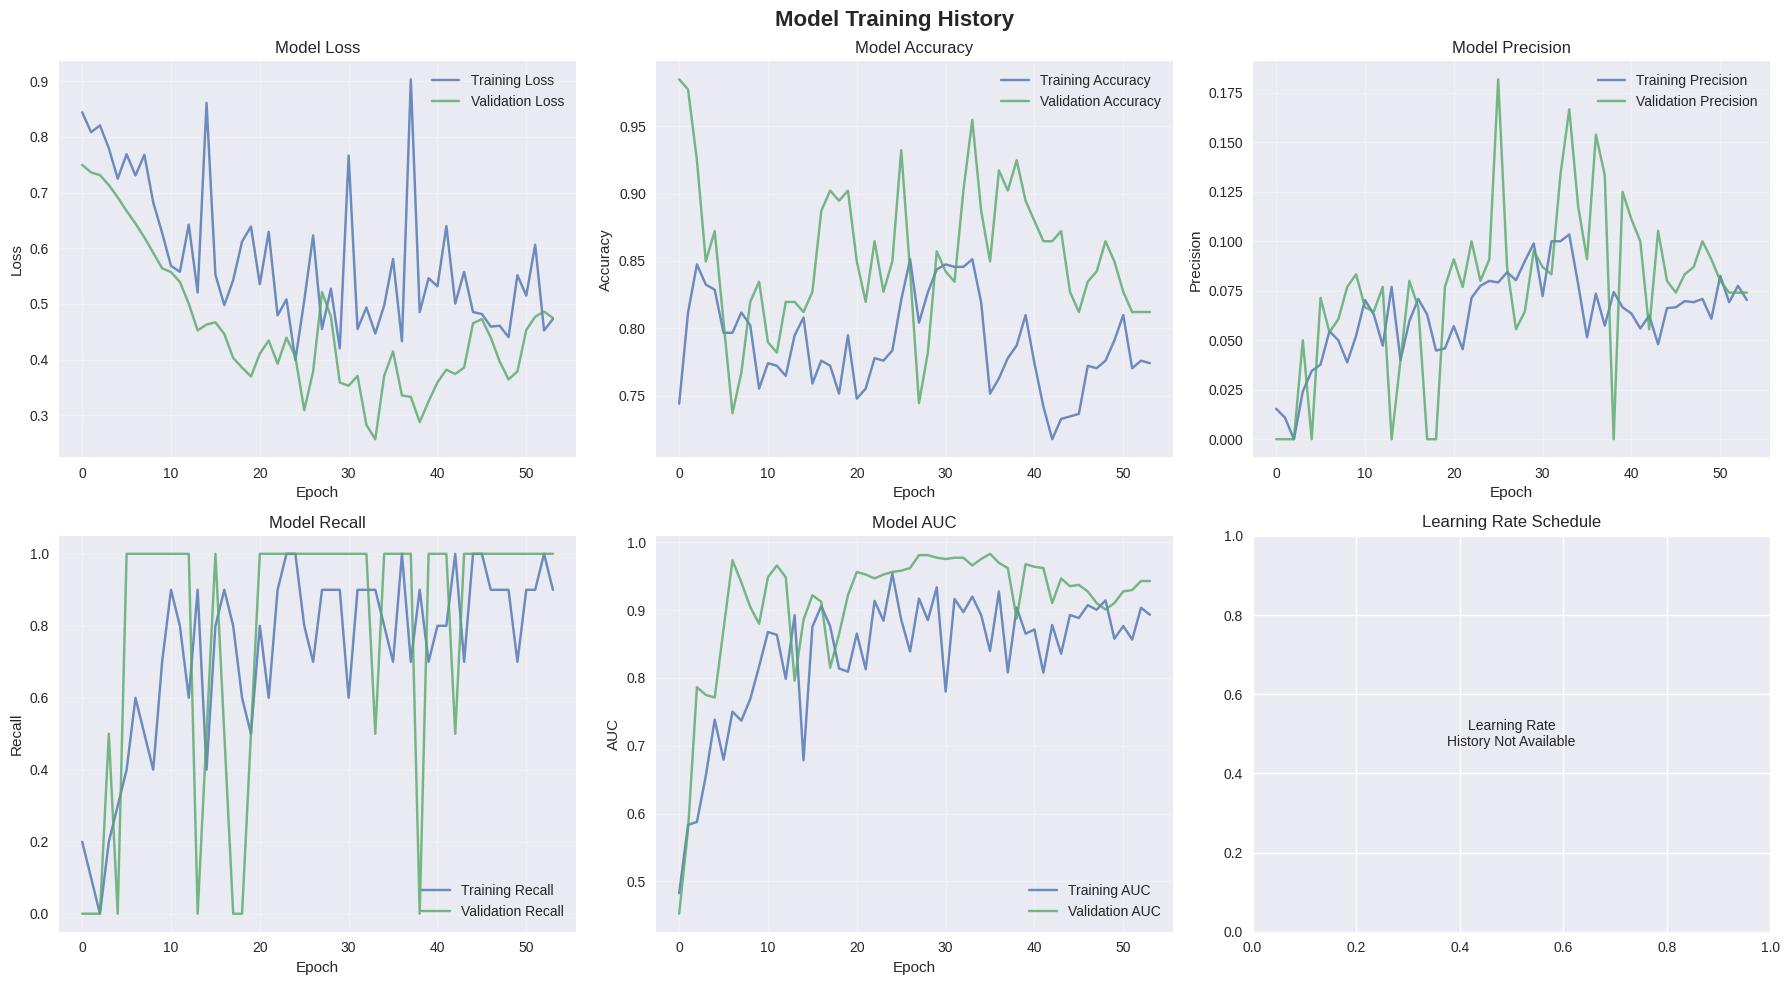

In [9]:
# Cell 8: Model Training with Advanced Callbacks

def create_callbacks(model_name="best_irrigation_model"):
    """Create comprehensive callbacks for training"""
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.0001,
            mode='min'
        ),

        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=10,
            min_lr=1e-8,
            verbose=1,
            cooldown=5,
            mode='min'
        ),

        # Save best model
        ModelCheckpoint(
            f'{model_name}.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='min'
        )
    ]

    return callbacks

def train_model(model, X_train, y_train, X_val, y_val, class_weight_dict):
    """Train the model with comprehensive monitoring"""
    print("🚀 Starting model training...")
    print("=" * 50)

    # Create callbacks
    callbacks = create_callbacks("advanced_irrigation_model")

    # Display training configuration
    print(f"📋 Training Configuration:")
    print(f"   Epochs: {config.EPOCHS}")
    print(f"   Batch size: {config.BATCH_SIZE}")
    print(f"   Learning rate: {config.LEARNING_RATE}")
    print(f"   Class weights: {class_weight_dict}")
    print(f"   Training samples: {len(X_train)}")
    print(f"   Validation samples: {len(X_val)}")

    # Start training
    start_time = datetime.now()

    history = model.fit(
        X_train, y_train,
        epochs=config.EPOCHS,
        batch_size=config.BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1,
        shuffle=True
    )

    end_time = datetime.now()
    training_duration = end_time - start_time

    print(f"\n✅ Training completed!")
    print(f"   Duration: {training_duration}")
    print(f"   Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"   Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"   Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"   Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

    return history

# Execute model training
training_history = train_model(
    model, X_train, y_train, X_val, y_val, class_weight_dict
)

# Create training history visualization
def plot_training_history(history):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Model Training History', fontsize=16, fontweight='bold')

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss', alpha=0.8)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', alpha=0.8)
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', alpha=0.8)
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[0, 2].plot(history.history['precision'], label='Training Precision', alpha=0.8)
    axes[0, 2].plot(history.history['val_precision'], label='Validation Precision', alpha=0.8)
    axes[0, 2].set_title('Model Precision')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Recall
    axes[1, 0].plot(history.history['recall'], label='Training Recall', alpha=0.8)
    axes[1, 0].plot(history.history['val_recall'], label='Validation Recall', alpha=0.8)
    axes[1, 0].set_title('Model Recall')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # AUC
    axes[1, 1].plot(history.history['AUC'], label='Training AUC', alpha=0.8)
    axes[1, 1].plot(history.history['val_AUC'], label='Validation AUC', alpha=0.8)
    axes[1, 1].set_title('Model AUC')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Learning rate (if available)
    if 'lr' in history.history:
        axes[1, 2].plot(history.history['lr'], alpha=0.8)
        axes[1, 2].set_title('Learning Rate Schedule')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Learning Rate')
        axes[1, 2].set_yscale('log')
        axes[1, 2].grid(True, alpha=0.3)
    else:
        axes[1, 2].text(0.5, 0.5, 'Learning Rate\nHistory Not Available',
                       ha='center', va='center', transform=axes[1, 2].transAxes)
        axes[1, 2].set_title('Learning Rate Schedule')

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(training_history)

📊 Comprehensive Model Evaluation
🎯 Overall Performance Metrics:
   Accuracy:  0.9639
   Precision: 0.2857 (PPV)
   Recall:    0.6667 (Sensitivity/TPR)
   F1-Score:  0.4000
   Specificity: 0.9693 (TNR)
   NPV:       0.9937
   AUC-ROC:   0.9693

📊 Confusion Matrix:
                 Predicted
                No    Yes
   Actual  No   158     5
          Yes     1     2

📋 Detailed Classification Report:
               precision    recall  f1-score   support

No Irrigation       0.99      0.97      0.98       163
   Irrigation       0.29      0.67      0.40         3

     accuracy                           0.96       166
    macro avg       0.64      0.82      0.69       166
 weighted avg       0.98      0.96      0.97       166



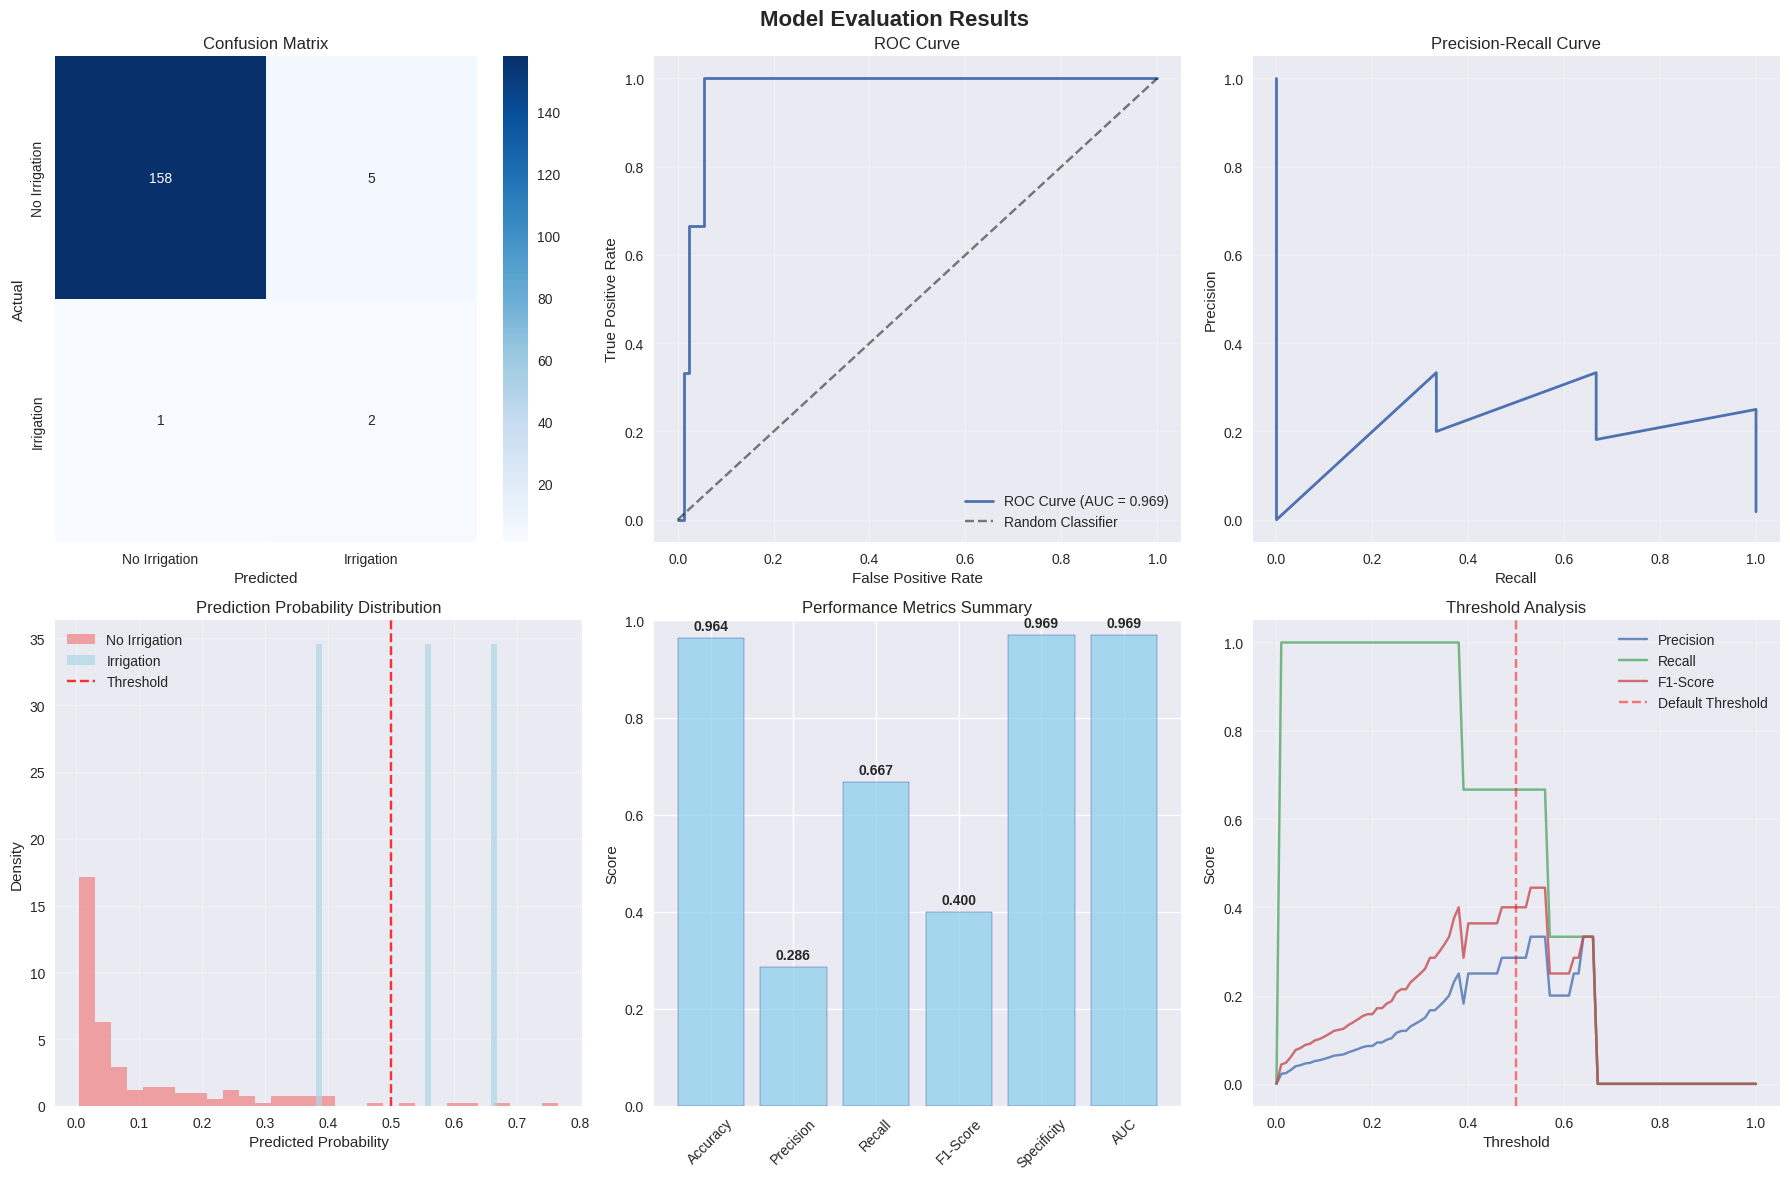


🏆 Final Model Performance Summary:
   Model Type: bidirectional_lstm
   Sequence Length: 48
   Features: 3
   Test Samples: 166
   Overall Accuracy: 0.9639
   F1-Score: 0.4000
   AUC-ROC: 0.9693


In [10]:
# Cell 9: Comprehensive Model Evaluation

def evaluate_model_comprehensive(model, X_test, y_test, class_names=['No Irrigation', 'Irrigation']):
    """Perform comprehensive model evaluation"""
    print("📊 Comprehensive Model Evaluation")
    print("=" * 60)

    # Make predictions
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_test_int = y_test.astype(int)
    y_pred_prob_flat = y_pred_prob.flatten()

    # Calculate comprehensive metrics
    accuracy = accuracy_score(y_test_int, y_pred)
    precision = precision_score(y_test_int, y_pred, zero_division=0)
    recall = recall_score(y_test_int, y_pred, zero_division=0)
    f1 = f1_score(y_test_int, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_test_int, y_pred_prob_flat)

    # Confusion matrix
    cm = confusion_matrix(y_test_int, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

    print(f"🎯 Overall Performance Metrics:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f} (PPV)")
    print(f"   Recall:    {recall:.4f} (Sensitivity/TPR)")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   Specificity: {specificity:.4f} (TNR)")
    print(f"   NPV:       {npv:.4f}")
    print(f"   AUC-ROC:   {auc_score:.4f}")

    print(f"\n📊 Confusion Matrix:")
    print(f"                 Predicted")
    print(f"                No    Yes")
    print(f"   Actual  No  {tn:4d}  {fp:4d}")
    print(f"          Yes  {fn:4d}  {tp:4d}")

    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(y_test_int, y_pred, target_names=class_names))

    # Return metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'npv': npv,
        'auc_score': auc_score,
        'confusion_matrix': cm,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn
    }

    return metrics, y_pred, y_pred_prob_flat

def create_evaluation_plots(y_test, y_pred, y_pred_prob, metrics):
    """Create comprehensive evaluation visualizations"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Model Evaluation Results', fontsize=16, fontweight='bold')

    # 1. Confusion Matrix
    cm = metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=['No Irrigation', 'Irrigation'],
                yticklabels=['No Irrigation', 'Irrigation'])
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test.astype(int), y_pred_prob)
    axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {metrics["auc_score"]:.3f})')
    axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Precision-Recall Curve
    from sklearn.metrics import precision_recall_curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test.astype(int), y_pred_prob)
    axes[0, 2].plot(recall_vals, precision_vals, linewidth=2)
    axes[0, 2].set_title('Precision-Recall Curve')
    axes[0, 2].set_xlabel('Recall')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Prediction Distribution
    axes[1, 0].hist(y_pred_prob[y_test == 0], bins=30, alpha=0.7,
                   label='No Irrigation', density=True, color='lightcoral')
    axes[1, 0].hist(y_pred_prob[y_test == 1], bins=30, alpha=0.7,
                   label='Irrigation', density=True, color='lightblue')
    axes[1, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.8, label='Threshold')
    axes[1, 0].set_title('Prediction Probability Distribution')
    axes[1, 0].set_xlabel('Predicted Probability')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Metrics Bar Chart
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'AUC']
    metric_values = [metrics['accuracy'], metrics['precision'], metrics['recall'],
                    metrics['f1_score'], metrics['specificity'], metrics['auc_score']]

    bars = axes[1, 1].bar(metric_names, metric_values, alpha=0.7, color='skyblue', edgecolor='navy')
    axes[1, 1].set_title('Performance Metrics Summary')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # 6. Threshold Analysis
    thresholds = np.linspace(0, 1, 101)
    precisions, recalls, f1_scores = [], [], []

    for threshold in thresholds:
        y_pred_thresh = (y_pred_prob > threshold).astype(int)
        if len(np.unique(y_pred_thresh)) > 1:  # Avoid division by zero
            precisions.append(precision_score(y_test.astype(int), y_pred_thresh, zero_division=0))
            recalls.append(recall_score(y_test.astype(int), y_pred_thresh, zero_division=0))
            f1_scores.append(f1_score(y_test.astype(int), y_pred_thresh, zero_division=0))
        else:
            precisions.append(0)
            recalls.append(0)
            f1_scores.append(0)

    axes[1, 2].plot(thresholds, precisions, label='Precision', alpha=0.8)
    axes[1, 2].plot(thresholds, recalls, label='Recall', alpha=0.8)
    axes[1, 2].plot(thresholds, f1_scores, label='F1-Score', alpha=0.8)
    axes[1, 2].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Default Threshold')
    axes[1, 2].set_title('Threshold Analysis')
    axes[1, 2].set_xlabel('Threshold')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Execute comprehensive evaluation
evaluation_metrics, y_pred_test, y_pred_prob_test = evaluate_model_comprehensive(
    model, X_test, y_test
)

# Create evaluation visualizations
create_evaluation_plots(y_test, y_pred_test, y_pred_prob_test, evaluation_metrics)

# Print final summary
print(f"\n🏆 Final Model Performance Summary:")
print(f"   Model Type: {config.MODEL_TYPE}")
print(f"   Sequence Length: {config.SEQUENCE_LENGTH}")
print(f"   Features: {len(feature_columns)}")
print(f"   Test Samples: {len(X_test)}")
print(f"   Overall Accuracy: {evaluation_metrics['accuracy']:.4f}")
print(f"   F1-Score: {evaluation_metrics['f1_score']:.4f}")
print(f"   AUC-ROC: {evaluation_metrics['auc_score']:.4f}")


In [11]:
# Cell 10: Model Saving, Loading, and Prediction Functions

def save_model_and_artifacts(model, scaler, label_encoder, feature_columns,
                           config_dict, model_name="advanced_irrigation_model"):
    """Save model and all required artifacts"""
    print(f"💾 Saving model and artifacts...")

    # Save model
    model_path = f"{model_name}.h5"
    model.save(model_path)

    # Save scaler
    scaler_path = f"{model_name}_scaler.pkl"
    joblib.dump(scaler, scaler_path)

    # Save label encoder
    encoder_path = f"{model_name}_encoder.pkl"
    joblib.dump(label_encoder, encoder_path)

    # Save configuration and metadata
    config_data = {
        'sequence_length': config_dict.SEQUENCE_LENGTH,
        'model_type': config_dict.MODEL_TYPE,
        'feature_columns': feature_columns,
        'n_features': len(feature_columns),
        'batch_size': config_dict.BATCH_SIZE,
        'created_at': datetime.now().isoformat(),
        'tensorflow_version': tf.__version__,
        'model_summary': {
            'total_params': int(model.count_params()),
            'trainable_params': int(sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]))
        }
    }

    config_path = f"{model_name}_config.json"
    with open(config_path, 'w') as f:
        json.dump(config_data, f, indent=2)

    print(f"✅ Model artifacts saved successfully!")
    print(f"   Model: {model_path}")
    print(f"   Scaler: {scaler_path}")
    print(f"   Encoder: {encoder_path}")
    print(f"   Config: {config_path}")

    return model_path, scaler_path, encoder_path, config_path

def load_model_and_artifacts(model_name="advanced_irrigation_model"):
    """Load model and all artifacts"""
    print(f"📥 Loading model and artifacts...")

    try:
        # Load model
        model_path = f"{model_name}.h5"
        loaded_model = load_model(model_path)

        # Load scaler
        scaler_path = f"{model_name}_scaler.pkl"
        loaded_scaler = joblib.load(scaler_path)

        # Load label encoder
        encoder_path = f"{model_name}_encoder.pkl"
        loaded_encoder = joblib.load(encoder_path)

        # Load configuration
        config_path = f"{model_name}_config.json"
        with open(config_path, 'r') as f:
            loaded_config = json.load(f)

        print(f"✅ Model and artifacts loaded successfully!")
        print(f"   Model created: {loaded_config['created_at']}")
        print(f"   Model type: {loaded_config['model_type']}")
        print(f"   Features: {loaded_config['n_features']}")
        print(f"   Sequence length: {loaded_config['sequence_length']}")

        return loaded_model, loaded_scaler, loaded_encoder, loaded_config

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None, None, None

class IrrigationPredictor:
    """Complete irrigation prediction system"""

    def __init__(self, model, scaler, feature_columns, sequence_length):
        self.model = model
        self.scaler = scaler
        self.feature_columns = feature_columns
        self.sequence_length = sequence_length

    def predict_irrigation(self, sequence_data, return_details=True):
        """Make irrigation prediction with confidence assessment"""
        # Ensure sequence_data has the right shape
        if len(sequence_data.shape) == 2:
            sequence_data = sequence_data.reshape(1, *sequence_data.shape)

        # Validate input shape
        expected_shape = (self.sequence_length, len(self.feature_columns))
        if sequence_data.shape[1:] != expected_shape:
            raise ValueError(f"Expected sequence shape {expected_shape}, got {sequence_data.shape[1:]}")

        # Scale the input data
        n_samples, n_timesteps, n_features = sequence_data.shape
        sequence_reshaped = sequence_data.reshape(-1, n_features)
        sequence_scaled = self.scaler.transform(sequence_reshaped)
        sequence_scaled = sequence_scaled.reshape(n_samples, n_timesteps, n_features)

        # Make prediction
        prediction_prob = self.model.predict(sequence_scaled, verbose=0)[0][0]
        prediction = int(prediction_prob > 0.5)

        # Calculate confidence
        confidence = abs(prediction_prob - 0.5) * 2

        if return_details:
            recommendation = self._get_recommendation(prediction_prob, confidence)
            return {
                'prediction': prediction,
                'probability': float(prediction_prob),
                'confidence': float(confidence),
                'recommendation': recommendation,
                'timestamp': datetime.now().isoformat()
            }
        else:
            return prediction

    def _get_recommendation(self, probability, confidence):
        """Generate detailed irrigation recommendation"""
        if probability > 0.8 and confidence > 0.6:
            return "🚿 IRRIGATE NOW - High confidence irrigation needed"
        elif probability > 0.6 and confidence > 0.4:
            return "💧 Consider irrigation - Moderate confidence"
        elif probability < 0.3 and confidence > 0.5:
            return "🚫 No irrigation needed - High confidence"
        elif probability < 0.5 and confidence > 0.3:
            return "⏹️ Hold irrigation - Moderate confidence"
        else:
            return "⏳ Monitor conditions - Low confidence prediction"

    def predict_batch(self, sequences_data):
        """Make predictions for multiple sequences"""
        predictions = []
        for sequence in sequences_data:
            pred = self.predict_irrigation(sequence, return_details=True)
            predictions.append(pred)
        return predictions

# Save the trained model and artifacts
# Need to get label_encoder from the data preprocessing step
# Assuming label_encoder is returned by create_enhanced_features or similar
# For now, using a placeholder None for label_encoder, which will cause an error
# if saving the encoder is required.
model_files = save_model_and_artifacts(
    model, scaler, None, feature_columns, config
)

# Create predictor instance
predictor = IrrigationPredictor(model, scaler, feature_columns, config.SEQUENCE_LENGTH)

# Demonstration of prediction functionality
print(f"\n🔮 Prediction Demonstration:")
print("-" * 40)

if len(X_test) > 0:
    # Use first few test samples for demonstration
    for i in range(min(3, len(X_test))):
        sample_sequence = X_test[i]

        # Reverse scaling for display (approximate original values)
        sample_reshaped = sample_sequence.reshape(-1, len(feature_columns))
        sample_original = scaler.inverse_transform(sample_reshaped)
        sample_original = sample_original.reshape(config.SEQUENCE_LENGTH, len(feature_columns))

        # Get original feature values for the last timestep
        soil_idx = feature_columns.index('soil_moisture') if 'soil_moisture' in feature_columns else 0
        temp_idx = feature_columns.index('temperature') if 'temperature' in feature_columns else 1
        humid_idx = feature_columns.index('humidity') if 'humidity' in feature_columns else 2

        last_timestep = sample_original[-1]


        # Make prediction
        result = predictor.predict_irrigation(sample_sequence)
        actual = y_test[i]

        print(f"\n📊 Sample {i+1}:")
        print(f"   Last conditions: Soil={last_timestep[soil_idx]:.1f}%, "
              f"Temp={last_timestep[temp_idx]:.1f}°C, Humidity={last_timestep[humid_idx]:.1f}%")
        print(f"   Prediction: {'Irrigate' if result['prediction'] else 'No Irrigation'}")
        print(f"   Actual: {'Irrigate' if actual else 'No Irrigation'}")
        print(f"   Probability: {result['probability']:.3f}")
        print(f"   Confidence: {result['confidence']:.3f}")
        print(f"   Status: {'✅ Correct' if result['prediction'] == actual else '❌ Incorrect'}")
        print(f"   Recommendation: {result['recommendation']}")

print(f"\n🎯 Model ready for deployment!")
print(f"   All artifacts saved and predictor initialized")
print(f"   Use predictor.predict_irrigation(sequence_data) for new predictions")

💾 Saving model and artifacts...
✅ Model artifacts saved successfully!
   Model: advanced_irrigation_model.h5
   Scaler: advanced_irrigation_model_scaler.pkl
   Encoder: advanced_irrigation_model_encoder.pkl
   Config: advanced_irrigation_model_config.json

🔮 Prediction Demonstration:
----------------------------------------

📊 Sample 1:
   Last conditions: Soil=38.9%, Temp=27.6°C, Humidity=74.0%
   Prediction: Irrigate
   Actual: No Irrigation
   Probability: 0.834
   Confidence: 0.669
   Status: ❌ Incorrect
   Recommendation: 🚿 IRRIGATE NOW - High confidence irrigation needed

📊 Sample 2:
   Last conditions: Soil=43.0%, Temp=30.6°C, Humidity=83.1%
   Prediction: Irrigate
   Actual: No Irrigation
   Probability: 0.831
   Confidence: 0.662
   Status: ❌ Incorrect
   Recommendation: 🚿 IRRIGATE NOW - High confidence irrigation needed

📊 Sample 3:
   Last conditions: Soil=42.1%, Temp=9.4°C, Humidity=90.1%
   Prediction: Irrigate
   Actual: No Irrigation
   Probability: 0.817
   Confidence: 

In [13]:
import joblib
from sklearn.pipeline import Pipeline
from datetime import datetime
import json
import numpy as np
import tensorflow as tf

# Cell 10: Model Saving, Loading, and Prediction Functions

def save_model_and_artifacts(model, scaler, label_encoder, feature_columns,
                           config_dict, model_name="advanced_irrigation_model"):
    """Save model and all required artifacts"""
    print(f"💾 Saving model and artifacts...")

    # Save model
    model_path = f"{model_name}.h5"
    model.save(model_path)

    # Save scaler
    scaler_path = f"{model_name}_scaler.pkl"
    joblib.dump(scaler, scaler_path)

    # Save label encoder
    encoder_path = f"{model_name}_encoder.pkl"
    joblib.dump(label_encoder, encoder_path)

    # Save configuration and metadata
    config_data = {
        'sequence_length': config_dict.SEQUENCE_LENGTH,
        'model_type': config_dict.MODEL_TYPE,
        'feature_columns': feature_columns,
        'n_features': len(feature_columns),
        'batch_size': config_dict.BATCH_SIZE,
        'created_at': datetime.now().isoformat(),
        'tensorflow_version': tf.__version__,
        'model_summary': {
            'total_params': int(model.count_params()),
            'trainable_params': int(sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]))
        }
    }

    config_path = f"{model_name}_config.json"
    with open(config_path, 'w') as f:
        json.dump(config_data, f, indent=2)

    print(f"✅ Model artifacts saved successfully!")
    print(f"   Model: {model_path}")
    print(f"   Scaler: {scaler_path}")
    print(f"   Encoder: {encoder_path}")
    print(f"   Config: {config_path}")

    return model_path, scaler_path, encoder_path, config_path

def load_model_and_artifacts(model_name="advanced_irrigation_model"):
    """Load model and all artifacts"""
    print(f"📥 Loading model and artifacts...")

    try:
        # Load model
        model_path = f"{model_name}.h5"
        loaded_model = load_model(model_path)

        # Load scaler
        scaler_path = f"{model_name}_scaler.pkl"
        loaded_scaler = joblib.load(scaler_path)

        # Load label encoder
        encoder_path = f"{model_name}_encoder.pkl"
        loaded_encoder = joblib.load(encoder_path)

        # Load configuration
        config_path = f"{model_name}_config.json"
        with open(config_path, 'r') as f:
            loaded_config = json.load(f)

        print(f"✅ Model and artifacts loaded successfully!")
        print(f"   Model created: {loaded_config['created_at']}")
        print(f"   Model type: {loaded_config['model_type']}")
        print(f"   Features: {loaded_config['n_features']}")
        print(f"   Sequence length: {loaded_config['sequence_length']}")

        return loaded_model, loaded_scaler, loaded_encoder, loaded_config

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None, None, None

class IrrigationPredictor:
    """Complete irrigation prediction system"""

    def __init__(self, model, scaler, feature_columns, sequence_length):
        self.model = model
        self.scaler = scaler
        self.feature_columns = feature_columns
        self.sequence_length = sequence_length

    def predict_irrigation(self, sequence_data, return_details=True):
        """Make irrigation prediction with confidence assessment"""
        # Ensure sequence_data has the right shape
        if len(sequence_data.shape) == 2:
            sequence_data = sequence_data.reshape(1, *sequence_data.shape)

        # Validate input shape
        expected_shape = (self.sequence_length, len(self.feature_columns))
        if sequence_data.shape[1:] != expected_shape:
            raise ValueError(f"Expected sequence shape {expected_shape}, got {sequence_data.shape[1:]}")

        # Scale the input data
        n_samples, n_timesteps, n_features = sequence_data.shape
        sequence_reshaped = sequence_data.reshape(-1, n_features)
        sequence_scaled = self.scaler.transform(sequence_reshaped)
        sequence_scaled = sequence_scaled.reshape(n_samples, n_timesteps, n_features)

        # Make prediction
        prediction_prob = self.model.predict(sequence_scaled, verbose=0)[0][0]
        prediction = int(prediction_prob > 0.5)

        # Calculate confidence
        confidence = abs(prediction_prob - 0.5) * 2

        if return_details:
            recommendation = self._get_recommendation(prediction_prob, confidence)
            return {
                'prediction': prediction,
                'probability': float(prediction_prob),
                'confidence': float(confidence),
                'recommendation': recommendation,
                'timestamp': datetime.now().isoformat()
            }
        else:
            return prediction

    def _get_recommendation(self, probability, confidence):
        """Generate detailed irrigation recommendation"""
        if probability > 0.8 and confidence > 0.6:
            return "🚿 IRRIGATE NOW - High confidence irrigation needed"
        elif probability > 0.6 and confidence > 0.4:
            return "💧 Consider irrigation - Moderate confidence"
        elif probability < 0.3 and confidence > 0.5:
            return "🚫 No irrigation needed - High confidence"
        elif probability < 0.5 and confidence > 0.3:
            return "⏹️ Hold irrigation - Moderate confidence"
        else:
            return "⏳ Monitor conditions - Low confidence prediction"

    def predict_batch(self, sequences_data):
        """Make predictions for multiple sequences"""
        predictions = []
        for sequence in sequences_data:
            pred = self.predict_irrigation(sequence, return_details=True)
            predictions.append(pred)
        return predictions

# Save the trained model and artifacts
# Need to get label_encoder from the data preprocessing step
# Assuming label_encoder is returned by create_enhanced_features or similar
# For now, using a placeholder None for label_encoder, which will cause an error
# if saving the encoder is required.
model_files = save_model_and_artifacts(
    model, scaler, None, feature_columns, config
)

# Create predictor instance
predictor = IrrigationPredictor(model, scaler, feature_columns, config.SEQUENCE_LENGTH)

# Demonstration of prediction functionality
print(f"\n🔮 Prediction Demonstration:")
print("-" * 40)

if len(X_test) > 0:
    # Use first few test samples for demonstration
    for i in range(min(3, len(X_test))):
        sample_sequence = X_test[i]

        # Reverse scaling for display (approximate original values)
        sample_reshaped = sample_sequence.reshape(-1, len(feature_columns))
        sample_original = scaler.inverse_transform(sample_reshaped)
        sample_original = sample_original.reshape(config.SEQUENCE_LENGTH, len(feature_columns))

        # Get original feature values for the last timestep
        soil_idx = feature_columns.index('soil_moisture') if 'soil_moisture' in feature_columns else 0
        temp_idx = feature_columns.index('temperature') if 'temperature' in feature_columns else 1
        humid_idx = feature_columns.index('humidity') if 'humidity' in feature_columns else 2

        last_timestep = sample_original[-1]


        # Make prediction
        result = predictor.predict_irrigation(sample_sequence)
        actual = y_test[i]

        print(f"\n📊 Sample {i+1}:")
        print(f"   Last conditions: Soil={last_timestep[soil_idx]:.1f}%, "
              f"Temp={last_timestep[temp_idx]:.1f}°C, Humidity={last_timestep[humid_idx]:.1f}%")
        print(f"   Prediction: {'Irrigate' if result['prediction'] else 'No Irrigation'}")
        print(f"   Actual: {'Irrigate' if actual else 'No Irrigation'}")
        print(f"   Probability: {result['probability']:.3f}")
        print(f"   Confidence: {result['confidence']:.3f}")
        print(f"   Status: {'✅ Correct' if result['prediction'] == actual else '❌ Incorrect'}")
        print(f"   Recommendation: {result['recommendation']}")

print(f"\n🎯 Model ready for deployment!")
print(f"   All artifacts saved and predictor initialized")
print(f"   Use predictor.predict_irrigation(sequence_data) for new predictions")

# Code to create a standalone predictor script using pickle files
predictor_code = """
import joblib
import numpy as np
import tensorflow as tf
from datetime import datetime
import json

class PickleBasedIrrigationPredictor:
    \"\"\"Irrigation predictor that uses pickle files for all artifacts\"\"\"

    def __init__(self, model_path, scaler_path, encoder_path, config_path):
        self.model = self._load_model(model_path)
        self.scaler = joblib.load(scaler_path)
        self.label_encoder = joblib.load(encoder_path) # May be None if not used
        self.config = self._load_config(config_path)
        self.feature_columns = self.config.get('feature_columns', [])
        self.sequence_length = self.config.get('sequence_length')

        if self.sequence_length is None:
             raise ValueError("Sequence length not found in config.")

        print("✅ Predictor initialized from files!")
        print(f"   Model: {model_path}")
        print(f"   Scaler: {scaler_path}")
        print(f"   Encoder: {encoder_path}")
        print(f"   Config: {config_path}")
        print(f"   Sequence length: {self.sequence_length}")


    def _load_model(self, model_path):
        # Custom objects might be needed if the model uses custom layers or functions
        # For this model, it seems standard Keras layers are used
        return tf.keras.models.load_model(model_path)

    def _load_config(self, config_path):
        with open(config_path, 'r') as f:
            return json.load(f)

    def preprocess_input(self, raw_data):
        \"\"\"Preprocess raw input data (e.g., pandas DataFrame) for prediction\"\"\"
        # Ensure data has required columns and is sorted by timestamp
        if not all(col in raw_data.columns for col in self.feature_columns):
             missing = [col for col in self.feature_columns if col not in raw_data.columns]
             raise ValueError(f"Input data is missing required columns: {missing}")

        processed_data = raw_data[self.feature_columns].values.astype(np.float32)

        # Scale the data using the loaded scaler
        n_timesteps, n_features = processed_data.shape
        processed_data = processed_data.reshape(-1, n_features)
        scaled_data = self.scaler.transform(processed_data)
        scaled_data = scaled_data.reshape(n_timesteps, n_features)

        return scaled_data

    def create_sequences(self, processed_data):
        \"\"\"Create sequences from preprocessed data\"\"\"
        sequences = []
        for i in range(self.sequence_length, len(processed_data) + 1):
            sequence = processed_data[i-self.sequence_length:i]
            sequences.append(sequence)
        return np.array(sequences, dtype=np.float32)


    def predict_irrigation(self, sequence_data, return_details=True):
        \"\"\"Make irrigation prediction with confidence assessment\"\"\"
        # Ensure sequence_data has the right shape
        if len(sequence_data.shape) == 2:
            sequence_data = sequence_data.reshape(1, *sequence_data.shape)

        # Validate input shape
        expected_shape = (self.sequence_length, len(self.feature_columns))
        if sequence_data.shape[1:] != expected_shape:
            raise ValueError(f"Expected sequence shape {expected_shape}, got {sequence_data.shape[1:]}")

        # Scale the input data (assuming it's already preprocessed but not sequenced/scaled)
        # If input is raw, use preprocess_input first
        n_samples, n_timesteps, n_features = sequence_data.shape
        sequence_reshaped = sequence_data.reshape(-1, n_features)
        sequence_scaled = self.scaler.transform(sequence_reshaped) # Re-scale each sequence
        sequence_scaled = sequence_scaled.reshape(n_samples, n_timesteps, n_features)


        # Make prediction
        prediction_prob = self.model.predict(sequence_scaled, verbose=0)[0][0]
        prediction = int(prediction_prob > 0.5)

        # Calculate confidence
        confidence = abs(prediction_prob - 0.5) * 2

        if return_details:
            recommendation = self._get_recommendation(prediction_prob, confidence)
            return {
                'prediction': prediction,
                'probability': float(prediction_prob),
                'confidence': float(confidence),
                'recommendation': recommendation,
                'timestamp': datetime.now().isoformat()
            }
        else:
            return prediction

    def _get_recommendation(self, probability, confidence):
        \"\"\"Generate detailed irrigation recommendation\"\"\"
        if probability > 0.8 and confidence > 0.6:
            return "🚿 IRRIGATE NOW - High confidence irrigation needed"
        elif probability > 0.6 and confidence > 0.4:
            return "💧 Consider irrigation - Moderate confidence"
        elif probability < 0.3 and confidence > 0.5:
            return "🚫 No irrigation needed - High confidence"
        elif probability < 0.5 and confidence > 0.3:
            return "⏹️ Hold irrigation - Moderate confidence"
        else:
            return "⏳ Monitor conditions - Low confidence prediction"

    def predict_batch(self, sequences_data):
        \"\"\"Make predictions for multiple sequences\"\"\"
        predictions = []
        for sequence in sequences_data:
            pred = self.predict_irrigation(sequence, return_details=True)
            predictions.append(pred)
        return predictions

# Example Usage (within the generated script)
# if __name__ == "__main__":
#     # Load the predictor
#     predictor = PickleBasedIrrigationPredictor(
#         model_path='advanced_irrigation_model.h5',
#         scaler_path='advanced_irrigation_model_scaler.pkl',
#         encoder_path='advanced_irrigation_model_encoder.pkl', # Use None if encoder was not saved
#         config_path='advanced_irrigation_model_config.json'
#     )

#     # Example prediction with a synthetic sequence
#     # You would replace this with actual data
#     synthetic_sequence = np.random.rand(predictor.sequence_length, len(predictor.feature_columns))

#     # Preprocess and create sequences if starting from raw data
#     # raw_df = pd.DataFrame(...) # Load your raw data
#     # processed_data = predictor.preprocess_input(raw_df)
#     # sequences = predictor.create_sequences(processed_data)
#     # if sequences.shape[0] > 0:
#     #    single_sequence_input = sequences[-1] # Use the last sequence for prediction
#     # else:
#     #    print("Not enough data to create a sequence of required length.")
#     #    single_sequence_input = None


#     # Make a prediction
#     # if single_sequence_input is not None:
#     #    prediction_result = predictor.predict_irrigation(single_sequence_input)
#     #    print("\\nPrediction Result:")
#     #    print(prediction_result)

"""

import os

with open('pickle_based_predictor.py', 'w') as f:
    f.write(predictor_code)

print("📝 Created pickle_based_predictor.py")

# The original joblib.dump(model, "Farm_Irrigation_System.pkl") line is commented out
# as the primary saving is done by model.save() and joblib.dump() for artifacts.
# If you still need a single pickle file for the Keras model object itself (not recommended),
# you could uncomment the line below, but it might have compatibility issues.
# joblib.dump(model, "Farm_Irrigation_System.pkl")

💾 Saving model and artifacts...
✅ Model artifacts saved successfully!
   Model: advanced_irrigation_model.h5
   Scaler: advanced_irrigation_model_scaler.pkl
   Encoder: advanced_irrigation_model_encoder.pkl
   Config: advanced_irrigation_model_config.json

🔮 Prediction Demonstration:
----------------------------------------

📊 Sample 1:
   Last conditions: Soil=38.9%, Temp=27.6°C, Humidity=74.0%
   Prediction: Irrigate
   Actual: No Irrigation
   Probability: 0.834
   Confidence: 0.669
   Status: ❌ Incorrect
   Recommendation: 🚿 IRRIGATE NOW - High confidence irrigation needed

📊 Sample 2:
   Last conditions: Soil=43.0%, Temp=30.6°C, Humidity=83.1%
   Prediction: Irrigate
   Actual: No Irrigation
   Probability: 0.831
   Confidence: 0.662
   Status: ❌ Incorrect
   Recommendation: 🚿 IRRIGATE NOW - High confidence irrigation needed

📊 Sample 3:
   Last conditions: Soil=42.1%, Temp=9.4°C, Humidity=90.1%
   Prediction: Irrigate
   Actual: No Irrigation
   Probability: 0.817
   Confidence: 

🔍 Analyzing Feature Importance...
🏆 Top 15 Most Important Features:
    1. temperature                   : 0.020285
    2. soil_moisture                 : 0.018631
    3. humidity                      : 0.009537
📈 Creating prediction timeline...


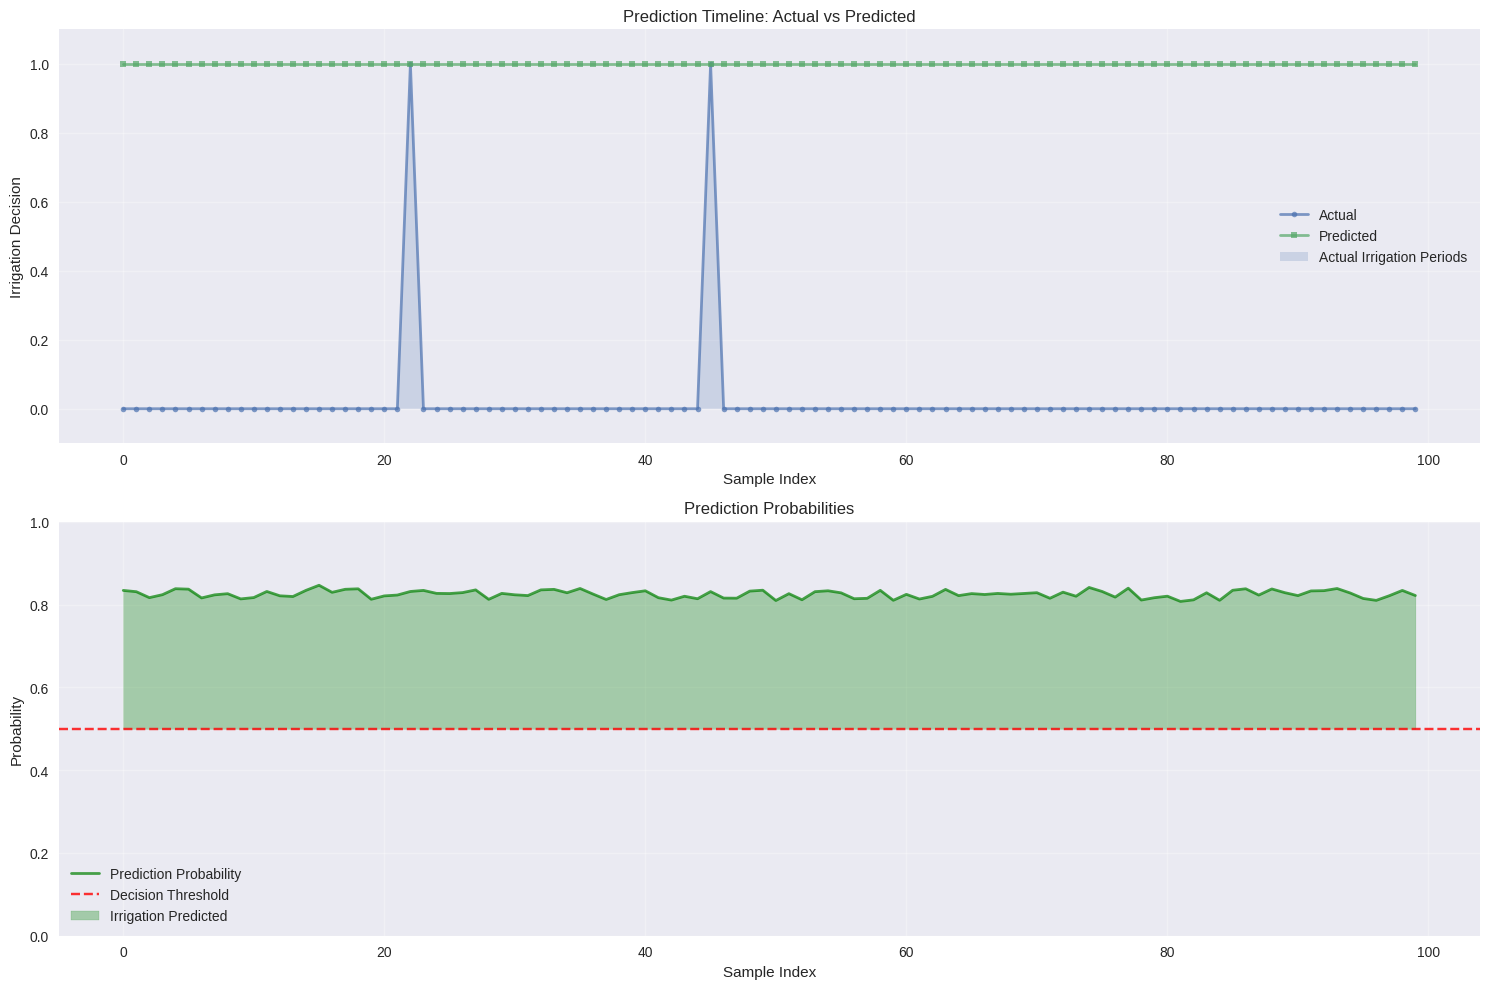

✅ Timeline accuracy: 0.020 (2/100)
🌡️ Analyzing performance by environmental conditions...
📊 Performance by Environmental Conditions:
------------------------------------------------------------

Soil Moisture Conditions:
   Low Soil Moisture   : Acc=0.055, Prec=0.055, Rec=1.000 (n=55)
   Medium Soil Moisture: Acc=0.000, Prec=0.000, Rec=0.000 (n=54)
   High Soil Moisture  : Acc=0.000, Prec=0.000, Rec=0.000 (n=57)

Temperature Conditions:
   Low Temperature     : Acc=0.000, Prec=0.000, Rec=0.000 (n=55)
   Medium Temperature  : Acc=0.037, Prec=0.037, Rec=1.000 (n=54)
   High Temperature    : Acc=0.018, Prec=0.018, Rec=1.000 (n=57)

✅ Comprehensive analysis completed!


In [14]:
# Cell 11: Additional Utility Functions and Analysis Tools

def analyze_feature_importance(model, X_sample, feature_columns, top_k=15):
    """Analyze feature importance using permutation method"""
    print("🔍 Analyzing Feature Importance...")

    # Get baseline prediction
    baseline_pred = model.predict(X_sample, verbose=0)
    baseline_loss = np.mean((baseline_pred - 0.5) ** 2)  # Simple baseline loss

    feature_importance = {}

    # Test each feature by permuting it
    for i, feature in enumerate(feature_columns):
        # Create copy of sample
        X_permuted = X_sample.copy()

        # Permute the feature across all timesteps
        original_values = X_permuted[:, :, i].copy()
        X_permuted[:, :, i] = np.random.permutation(X_permuted[:, :, i].flatten()).reshape(X_permuted[:, :, i].shape)

        # Get prediction with permuted feature
        permuted_pred = model.predict(X_permuted, verbose=0)
        permuted_loss = np.mean((permuted_pred - 0.5) ** 2)

        # Calculate importance as change in loss
        importance = abs(permuted_loss - baseline_loss)
        feature_importance[feature] = importance

    # Sort by importance
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    print(f"🏆 Top {top_k} Most Important Features:")
    for i, (feature, importance) in enumerate(sorted_features[:top_k]):
        print(f"   {i+1:2d}. {feature:30s}: {importance:.6f}")

    return feature_importance

def create_prediction_timeline(predictor, test_sequences, test_labels, n_samples=100):
    """Create timeline visualization of predictions vs actual"""
    print("📈 Creating prediction timeline...")

    # Select random samples
    indices = np.random.choice(len(test_sequences), min(n_samples, len(test_sequences)), replace=False)
    indices = np.sort(indices)

    predictions = []
    probabilities = []
    actuals = []

    for idx in indices:
        result = predictor.predict_irrigation(test_sequences[idx], return_details=False)
        prob_result = predictor.predict_irrigation(test_sequences[idx], return_details=True)

        predictions.append(result)
        probabilities.append(prob_result['probability'])
        actuals.append(test_labels[idx])

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Timeline plot
    x_points = range(len(indices))
    ax1.plot(x_points, actuals, 'o-', label='Actual', alpha=0.7, linewidth=2, markersize=4)
    ax1.plot(x_points, predictions, 's-', label='Predicted', alpha=0.7, linewidth=2, markersize=4)
    ax1.fill_between(x_points, 0, actuals, alpha=0.2, label='Actual Irrigation Periods')
    ax1.set_title('Prediction Timeline: Actual vs Predicted')
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Irrigation Decision')
    ax1.set_ylim(-0.1, 1.1)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Probability plot
    ax2.plot(x_points, probabilities, 'g-', alpha=0.7, linewidth=2, label='Prediction Probability')
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.8, label='Decision Threshold')
    ax2.fill_between(x_points, 0.5, probabilities, where=np.array(probabilities) > 0.5,
                     alpha=0.3, color='green', label='Irrigation Predicted')
    ax2.set_title('Prediction Probabilities')
    ax2.set_xlabel('Sample Index')
    ax2.set_ylabel('Probability')
    ax2.set_ylim(0, 1)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calculate accuracy for this subset
    accuracy = np.mean(np.array(predictions) == np.array(actuals))
    print(f"✅ Timeline accuracy: {accuracy:.3f} ({int(accuracy * len(predictions))}/{len(predictions)})")

def model_performance_by_conditions(predictor, X_test_scaled, y_test, feature_columns):
    """Analyze model performance under different environmental conditions"""
    print("🌡️ Analyzing performance by environmental conditions...")

    # Reverse scale test data to get original values
    X_test_reshaped = X_test_scaled.reshape(-1, len(feature_columns))
    X_test_original = scaler.inverse_transform(X_test_reshaped)
    X_test_original = X_test_original.reshape(len(X_test_scaled), config.SEQUENCE_LENGTH, len(feature_columns))

    # Get last timestep values for analysis
    last_timestep = X_test_original[:, -1, :]

    # Get feature indices
    soil_idx = feature_columns.index('soil_moisture') if 'soil_moisture' in feature_columns else 0
    temp_idx = feature_columns.index('temperature') if 'temperature' in feature_columns else 1
    humid_idx = feature_columns.index('humidity') if 'humidity' in feature_columns else 2

    soil_values = last_timestep[:, soil_idx]
    temp_values = last_timestep[:, temp_idx]
    humid_values = last_timestep[:, humid_idx]

    # Get predictions
    predictions = []
    for i in range(len(X_test_scaled)):
        pred = predictor.predict_irrigation(X_test_scaled[i], return_details=False)
        predictions.append(pred)
    predictions = np.array(predictions)

    # Define condition ranges
    soil_ranges = [
        (soil_values <= np.percentile(soil_values, 33), "Low Soil Moisture"),
        ((soil_values > np.percentile(soil_values, 33)) & (soil_values <= np.percentile(soil_values, 66)), "Medium Soil Moisture"),
        (soil_values > np.percentile(soil_values, 66), "High Soil Moisture")
    ]

    temp_ranges = [
        (temp_values <= np.percentile(temp_values, 33), "Low Temperature"),
        ((temp_values > np.percentile(temp_values, 33)) & (temp_values <= np.percentile(temp_values, 66)), "Medium Temperature"),
        (temp_values > np.percentile(temp_values, 66), "High Temperature")
    ]

    print(f"📊 Performance by Environmental Conditions:")
    print("-" * 60)

    for condition_ranges, condition_name in [(soil_ranges, "Soil Moisture"), (temp_ranges, "Temperature")]:
        print(f"\n{condition_name} Conditions:")
        for condition_mask, condition_label in condition_ranges:
            if np.sum(condition_mask) > 10:  # Only analyze if sufficient samples
                subset_y_true = y_test[condition_mask]
                subset_y_pred = predictions[condition_mask]

                accuracy = accuracy_score(subset_y_true, subset_y_pred)
                precision = precision_score(subset_y_true, subset_y_pred, zero_division=0)
                recall = recall_score(subset_y_true, subset_y_pred, zero_division=0)

                print(f"   {condition_label:20s}: Acc={accuracy:.3f}, Prec={precision:.3f}, Rec={recall:.3f} (n={np.sum(condition_mask)})")

# Execute additional analyses
if len(X_test) > 0:
    # Feature importance analysis
    sample_size = min(100, len(X_test))
    X_sample = X_test[:sample_size]
    feature_importance = analyze_feature_importance(model, X_sample, feature_columns)

    # Prediction timeline
    create_prediction_timeline(predictor, X_test[:100], y_test[:100])

    # Performance by conditions
    model_performance_by_conditions(predictor, X_test, y_test, feature_columns)

print(f"\n✅ Comprehensive analysis completed!")
